---
# <center> Assignment 3 (ML for TS) - MVA 2021/2022
##### <center> Eya Ghamgui $~~$ eya.ghamgui@telecom-paris.fr

##### <center> Siwar Mhadhbi $~~$ siwar.mhadhbi@telecom-paris.fr

<center> $March~~ 18^{th}, 2022$

---

## Setup

**Imports**

In [ ]:
!pip install ruptures
!pip install loadmydata
!pip install geopandas
!pip install pygsp
!pip install contextily

In [ ]:
import scipy
import geopandas
import numpy as np
import pandas as pd
import seaborn as sns 
import ruptures as rpt
import contextily as cx
from pygsp import graphs
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from ruptures.metrics import hamming
from math import asin, cos, radians, sin, sqrt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist, squareform
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

sns.set_palette("tab10")

import warnings
warnings.filterwarnings("ignore")

**Utility functions & variables**

In [ ]:
CRS = "EPSG:4326"

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

In [ ]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [ ]:
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix ** 2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [ ]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """
    Return a line graph
    
    """
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

## Question 2: Model selection for change-point detection

In [ ]:
# List of breakpoints 
n_bkps_list = [2,4,6,8,10]

# List of number of samples 
T_list = [100,200,500,1000]

# List of Sigma 
sigma_list = [1,2,5,7]

# Dimension of the problem
d = 2

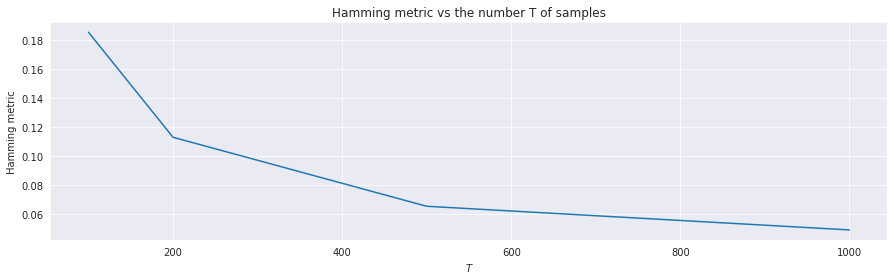

In [ ]:
# ------------------------------------------ First case ------------------------------------------ #

# Fix Sigma to 2 
sigma = 2 

# Compute the Hamming metric between the true segmentation 
# and the estimated segmentation in function of T
dist_list_T = []
for T in T_list : 
  dist_list_bkps = []

  # Average metric for different breackpoint values 
  for n_bkps in n_bkps_list :
    hamm_list = []

    # Try the experiment several times so that the result is stable and robust
    for _ in range(30):

      # Create the signal with its true breakpoints
      signal, bkps = rpt.datasets.pw_constant(n_samples=T, n_features=d, n_bkps=n_bkps, noise_std=sigma)
      size = T // 10

      # Compute the penality term  
      pen_Cp = 2*d*n_bkps*np.var(signal[:size][0])

      # Estimate breakpoints 
      algo = rpt.KernelCPD(kernel="linear").fit(signal)
      predicted_bkps = algo.predict(pen=pen_Cp)

      # Compute Hamming distance 
      hamm_list.append(hamming(bkps,predicted_bkps))

    dist_list_bkps.append(np.mean(hamm_list))
  dist_list_T.append(np.mean(dist_list_bkps))

# Visualize the average Hamming metric 
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(15,4))
  plt.plot(T_list, dist_list_T)
  plt.title('Hamming metric vs the number T of samples')
  plt.xlabel('$T$')
  plt.ylabel('Hamming metric')
  plt.show()

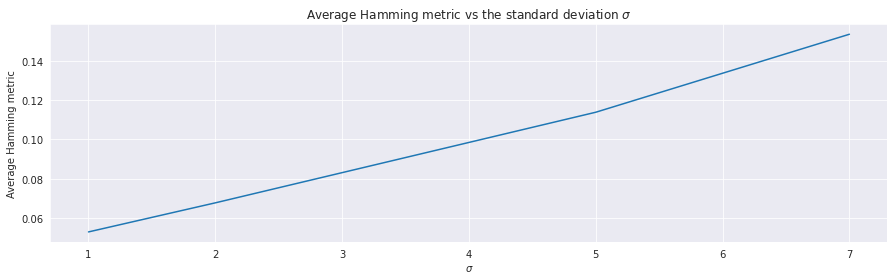

In [ ]:
# ------------------------------------------ Second case ------------------------------------------ #

# Fix T to 500
T = 500

# Compute the Hamming metric between the true segmentation 
# and the estimated segmentation in function of Sigma 
dist_list_sigma = []
for sigma in sigma_list : 
  dist_list_bkps = []

  # Average metric for different breackpoint values 
  for n_bkps in n_bkps_list : 
    hamm_list = []

    # Try the experiment several times so that the result is stable and robust
    for _ in range(30):

      # Create the signal with its true breakpoints
      signal, bkps = rpt.datasets.pw_constant(n_samples=T, n_features=d, n_bkps=n_bkps, noise_std=sigma)
      size = T // 10

      # Compute the penality term  
      pen_Cp = 2*d*n_bkps*np.var(signal[:size][0])

      # Estimate breakpoints 
      algo = rpt.KernelCPD(kernel="linear").fit(signal)
      predicted_bkps = algo.predict(pen=pen_Cp)

      # Compute Hamming distance 
      hamm_list.append(hamming(bkps,predicted_bkps))

    dist_list_bkps.append(np.mean(hamm_list))
  dist_list_sigma.append(np.mean(dist_list_bkps))

# Visualize the average Hamming metric 
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(15,4))
  plt.plot(sigma_list, dist_list_sigma)
  plt.title('Average Hamming metric vs the standard deviation $\sigma$')
  plt.xlabel('$\sigma$')
  plt.ylabel('Average Hamming metric')
  plt.show()

## Question 3: Slope Heuristics

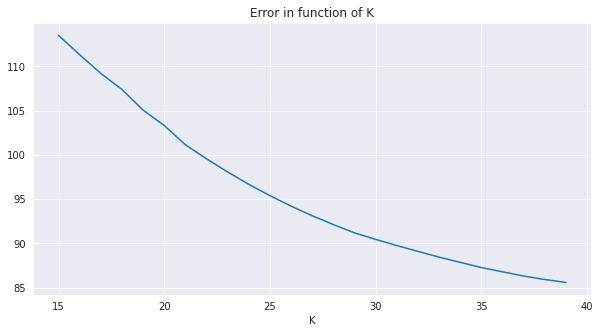

     => The estimated slope = -1.130584094243609


In [ ]:
def slope (y, T, plot = False) :
  """
  Function to compute the slope of the error 

  -----
  Inputs:
  
  y : numpy array 
      the signal 

  T : int 
      the number of samples 

  plot : boolean 
         if True, plot the error curve in function of K 

  """

  # Change point detector 
  algo = rpt.KernelCPD(kernel='linear').fit(y)
  
  error_list = []
  k_list = []
  for k in range(15, int(0.4*T)): 

    # Compute errors in function of number of breakpoints 
    predicted_bkps = algo.predict(n_bkps=k)
    error_list.append(algo.cost.sum_of_costs(predicted_bkps))
    k_list.append(k)

  if plot : 
    with sns.axes_style('darkgrid'):
      plt.figure(figsize=(10,5))
      plt.plot(k_list,error_list)
      plt.xlabel('K')
      plt.title('Error in function of K')
      plt.show()
  
  # Estimate the slope using a linear regressor 
  lin_reg = LinearRegression()
  lin_reg = lin_reg.fit(np.array(k_list).reshape(-1,1), np.array(error_list).reshape(-1,1))
  slope = lin_reg.coef_[0][0]

  return slope

signal, bkps = rpt.datasets.pw_constant(n_samples=100, n_features=2, n_bkps=1, noise_std=1)
s = slope (signal, 100, plot=True)
print(' '*4, '=> The estimated slope =', s)

In [ ]:
# List of breakpoints 
n_bkps_list = [2,4,6,8,10]

# List of number of samples 
T_list = [100,200,500,1000]

# List of Sigma 
sigma_list = [1,2,5,7]

# Dimension of the problem
d = 2

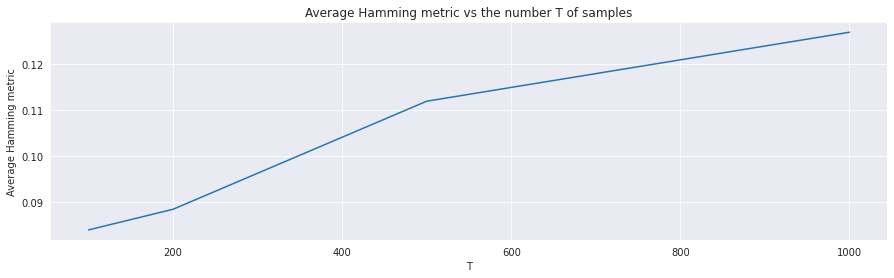

In [ ]:
# ------------------------------------------ First case ------------------------------------------ #

# Fix Sigma to 2 
sigma = 2 

# Compute the Hamming metric between the true segmentation 
# and the estimated segmentation in function of T
dist_list_T = []
for T in T_list : 
  dist_list_bkps = []

  # Average metric for different breackpoint values 
  for n_bkps in n_bkps_list : 
    hamm_list = []

    # Try the experiment several times so that the result is stable and robust
    for _ in range(10):

      # Create the signal with its true breakpoints
      signal, bkps = rpt.datasets.pw_constant(n_samples=T, n_features=d, n_bkps=n_bkps, noise_std=sigma)
      
      # Slope Heuristic 
      s = slope(signal,T)
      C_s = -T*s

      # Compute the penality term  
      pen_Cs = C_s*d/T

      # Estimate breakpoints 
      algo = rpt.KernelCPD(kernel="linear").fit(signal)
      predicted_bkps = algo.predict(pen=pen_Cs)

      # Compute Hamming distance
      hamm_list.append(hamming(bkps,predicted_bkps))   

    dist_list_bkps.append(np.mean(hamm_list))
  dist_list_T.append(np.mean(dist_list_bkps))

# Visualize the average Hamming metric 
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(15,4))
  plt.plot(T_list, dist_list_T)
  plt.title('Average Hamming metric vs the number T of samples')
  plt.xlabel('T')
  plt.ylabel('Average Hamming metric')
  plt.show()

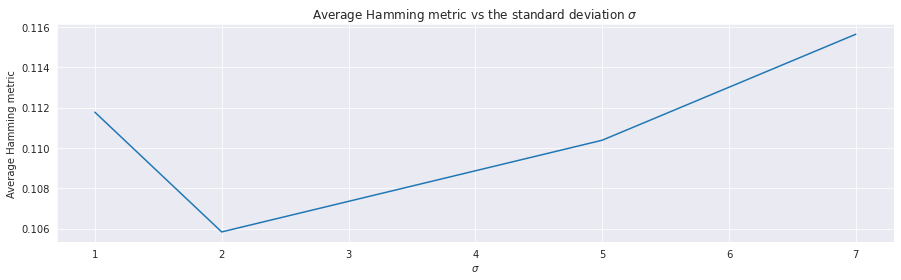

In [ ]:
# ------------------------------------------ Second case ------------------------------------------ #

# Fix T to 500
T = 500

# Compute the Hamming metric between the true segmentation 
# and the estimated segmentation in function of Sigma 
dist_list_sigma = []
for sigma in sigma_list : 
  dist_list_bkps = []

  # Average metric for different breackpoint values 
  for n_bkps in n_bkps_list : 
    hamm_list = []

    # Try the experiment several times so that the result is stable and robust
    for _ in range(10):

      # Create the signal with its true breakpoints
      signal, bkps = rpt.datasets.pw_constant(n_samples=T, n_features=d, n_bkps=n_bkps, noise_std=sigma)

      # Slope Heuristic 
      s = slope(signal,T)
      C_s = -T*s

      # Compute the penality term 
      pen_Cs = C_s*d/T

      # Estimate breakpoints 
      algo = rpt.KernelCPD(kernel="linear").fit(signal)
      predicted_bkps = algo.predict(pen=pen_Cs)

      # Compute Hamming distance 
      hamm_list.append(hamming(bkps,predicted_bkps))

    dist_list_bkps.append(np.mean(hamm_list))
  dist_list_sigma.append(np.mean(dist_list_bkps))

# Visualize the average Hamming metric 
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(15,4))
  plt.plot(sigma_list, dist_list_sigma)
  plt.title('Average Hamming metric vs the standard deviation $\sigma$')
  plt.xlabel('$\sigma$')
  plt.ylabel('Average Hamming metric')
  plt.show()

## **Wavelet transform for graph signals**

## Question 4

In [ ]:
# Functions to compute the kernel of Spectrum Adapted Graph Wavelets (SAGW)

def g_m(lambd, R, m, lambdn = 12, M = 9): 
  a = lambdn / (M + 1 - R)
  return g_u(lambd - a*m, R, a, lambdn = 12, M = 9)

def g_u(lambd, R, a, lambdn = 12, M = 9):
  if (lambd < 0) and (lambd >= -R*a):
    return  0.5 * (1 + np.cos(2*np.pi*(lambd/(a*R) + 0.5)))
  else:
    return 0 

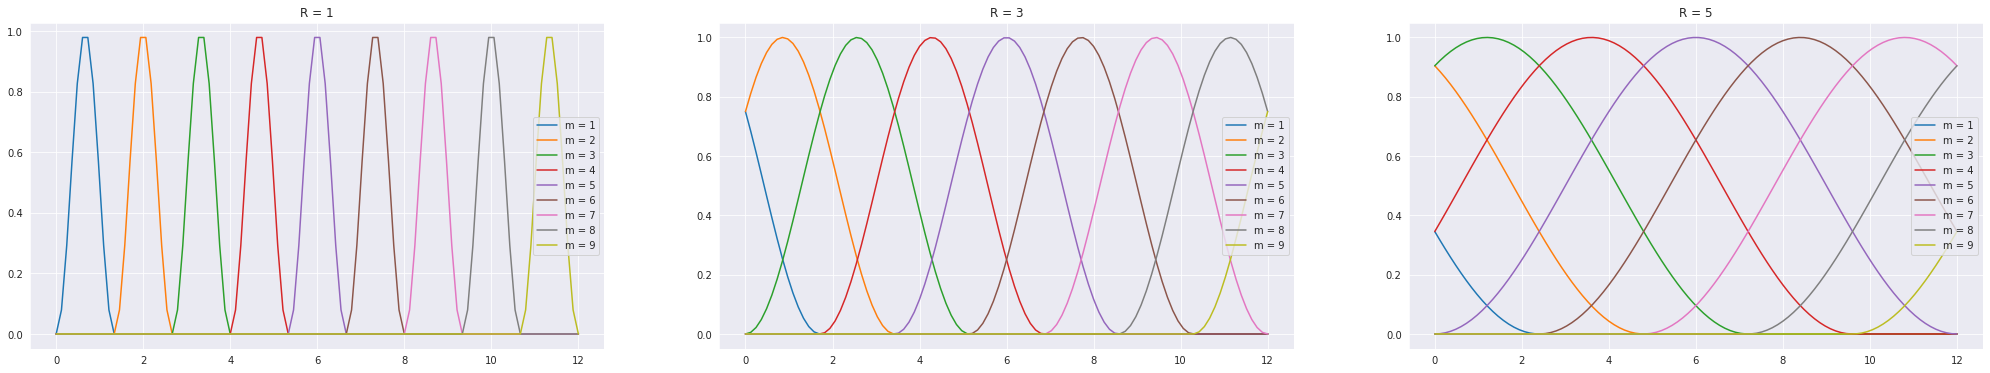

In [ ]:
# Initializations 
M = 9 
lambdn = 12
R_list = [1, 3, 5] 
lambda_list = np.linspace(0,lambdn,100)

# Plot the kernel functions
with sns.axes_style('darkgrid'):
  fig , ax = plt.subplots(1,3,figsize=(35,6))
  for i in range(len(R_list)):
    for m in range(1,M+1) :
      gm = []
      for x in lambda_list : 
        gm.append(g_m(x, R_list[i], m))
      ax[i].plot(lambda_list, gm, label='m = '+str(m))
      ax[i].legend()
    ax[i].set_title('R = '+str( R_list[i]))
  plt.show()

## Question 5

In [ ]:
# Load temperature data 
data_df, stations_df, description = load_molene_meteo_dataset()

# Convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


* **Remove all stations with missing values in the temperature**

In [ ]:
# Compute number of missing values 
MV = pd.DataFrame(temperature_df.isna().sum(axis=0).sort_values(ascending=False), columns=['Number of missing values'])

# Stations with missing values
print('\nStations with missing values:\n',MV[MV['Number of missing values']!=0].index)
print('\nNumber of stations to remove =', len(MV[MV['Number of missing values']!=0].index))
print('\nNumber of remaining stations =', len(MV[MV['Number of missing values']==0].index))

MV.head(55).style.set_properties(**{'background-color': '#c6ccd8'})


Stations with missing values:
 Index(['BATZ', 'BEG_MEIL', 'CAMARET', 'PLOUGONVELIN', 'RIEC SUR BELON',
       'ST NAZAIRE-MONTOIR', 'PLOUAY-SA', 'VANNES-MEUCON', 'LANNAERO',
       'PLOUDALMEZEAU', 'LANDIVISIAU', 'SIZUN', 'QUIMPER', 'OUESSANT-STIFF',
       'LANVEOC', 'ARZAL', 'BREST-GUIPAVAS', 'BRIGNOGAN'],
      dtype='object', name='station_name')

Number of stations to remove = 18

Number of remaining stations = 37


,Number of missing values
station_name,
BATZ,744
BEG_MEIL,744
CAMARET,744
PLOUGONVELIN,744
RIEC SUR BELON,144
ST NAZAIRE-MONTOIR,70
PLOUAY-SA,63
VANNES-MEUCON,50
LANNAERO,37


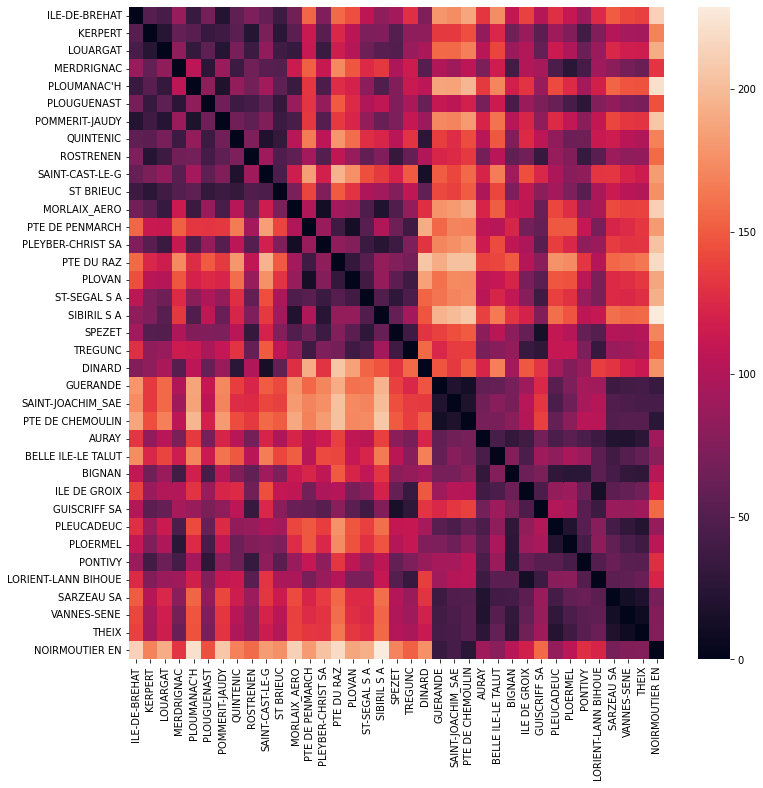

In [ ]:
# Remove all stations with missing values in the temperature
to_select = MV[MV['Number of missing values']==0].index
temperature_df = temperature_df[to_select]
stations_df = stations_df[stations_df['Nom'].isin(to_select)]

# Convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry= geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

plt.figure (figsize = (12,12))
sns.heatmap(dist_mat_square, xticklabels=stations_df.Nom, yticklabels=stations_df.Nom)
plt.show()

* **Choose the minimum threshold so that the network is connected and the average degree is at least 3**

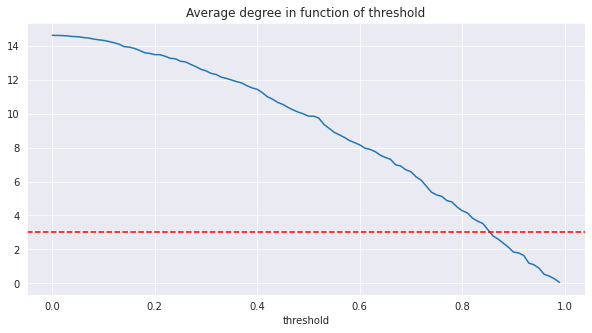

The graph is connected, and the average degree is equal to 3.664 with a threshold of 0.83


In [ ]:
# Median Heuristic
sigma = np.median(dist_mat_condensed) 

# List of thresholds
threshold = np.arange(0,1,0.01)

average_degree=[]
for th in threshold : 

  # Compute adjacency matrix
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, th))

  # Compute average degree 
  average_degree.append(np.mean(adjacency_matrix_gaussian.sum(axis=1)))

# Visualize the average degree in function of threshold
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(10,5))
  plt.plot(threshold,average_degree)
  plt.axhline(y=3,color = 'red', linestyle='--')
  plt.title('Average degree in function of threshold')
  plt.xlabel('threshold')
  plt.show()

# Compute the minimum threshold 
for th in threshold[::-1] : 
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, th))
  G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
  average_degree = np.mean(adjacency_matrix_gaussian.sum(axis=1))
  if G_gaussian.is_connected(recompute=True) and average_degree >= 3 :
    print(f"The graph is{'not ' if not G_gaussian.is_connected(recompute=True) else ''} connected, and the average degree is equal to {round(average_degree,3)} with a threshold of {round(th,2)}")
    break

* **Time where the signal is the least smooth & the smoothest**

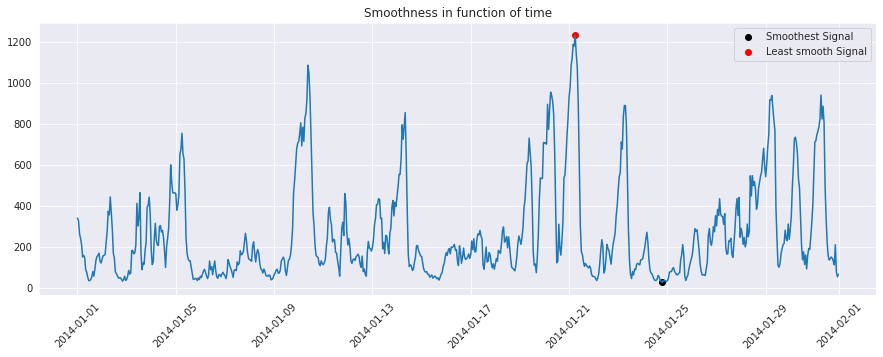



Time where the signal is the smoothest: 2014-01-24 19:00:00
Time where the signal is the least smooth: 2014-01-21 06:00:00


In [ ]:
# Compute the Laplacian matrix 
laplacian_matrix = G_gaussian.L.todense()

# Compute the smoothness 
smoothness = []
for date in temperature_df.index:
  signal = temperature_df.loc[date].to_numpy()
  smoothness.append(float(signal.T.dot(laplacian_matrix).dot(signal)))

# Visualize the smoothness in function of time 
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(15,5))
  plt.plot(temperature_df.index, smoothness)
  plt.scatter(temperature_df.index[np.argmin(smoothness)],np.min(smoothness) , c='k', label = 'Smoothest Signal')
  plt.scatter(temperature_df.index[np.argmax(smoothness)],np.max(smoothness) , c='r', label = 'Least smooth Signal')
  plt.legend()
  plt.title('Smoothness in function of time')
  plt.xticks(rotation=45)
  plt.show()


print(f"\n\nTime where the signal is the smoothest: {temperature_df.index[np.argmin(smoothness)]}")
print(f"Time where the signal is the least smooth: {temperature_df.index[np.argmax(smoothness)]}")

## Question 6

In [ ]:
def node_labels(index, plot = True):
  """
  Compute labels for a given signal

  -----
  Inputs: 

  index : int
          the index of a signal 

  plot : boolean 
         if True, plot the error curve in function of K 

  """
  # Select the signal
  f = temperature_df.loc[temperature_df.index[index]].to_numpy()

  # Compute the eigenvalues and eigenvectors of the Laplacian matrix 
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, 0.83))
  G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
  laplacian_matrix = G_gaussian.L.todense()
  eigenval, eigenvec = scipy.linalg.eig(laplacian_matrix)
  eigenval = np.real(eigenval)

  # Sort the eigenvalues and their corresponding eigenvectors 
  idx = eigenval.argsort()
  eigenval = eigenval[idx]
  eigenvec = eigenvec[:,idx]

  # Compute the Graph Fourier Transform (GFT) of the graph signal "f"
  f_hat = eigenvec.T @ f   

  M = 9
  R = 3
  
  labels_list = []
  for v in range(len(f)):
    W_v =[]
    for m in range(1,M+1):
      W = 0
      for i in range(len(eigenval)) :
        W += g_m(eigenval[i], R, m, lambdn=eigenval[-1]) * f_hat[i] * eigenvec[v,i]
      W_v.append(W)
    
    # Classify nodes into low/medium/high frequency
    val = [sum(np.abs(W_v[:3])**2),sum(np.abs(W_v[3:6])**2),sum(np.abs(W_v[6:])**2)]
    labels_list.append(np.argmax(val))

  # Display on the map the result 
  if plot:
    ax = stations_gdf.geometry.plot(figsize=(10, 5))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    G_gaussian.set_coordinates(stations_np)

    G_gaussian.plot_signal(np.array(labels_list), ax=ax)
    _ = ax.set_title(f"Measures on the {temperature_df.index[index]}.")

  return labels_list

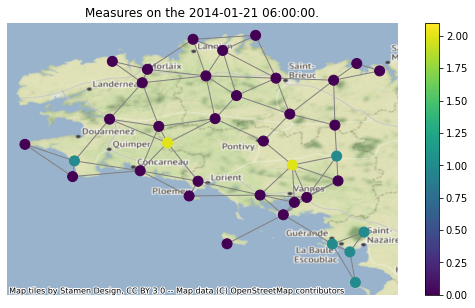

In [ ]:
# The least smooth signal
_ = node_labels(np.argmax(smoothness))

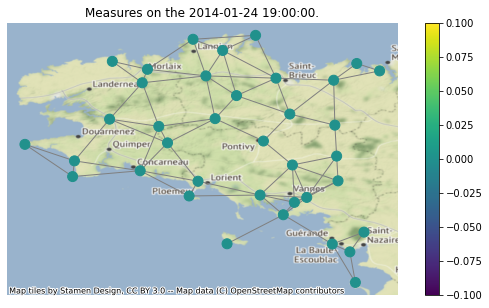

In [ ]:
# The smoothest signal 
_ = node_labels(np.argmin(smoothness))

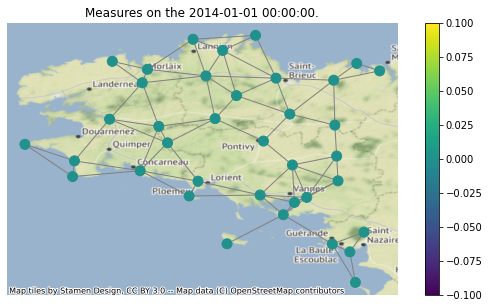

In [ ]:
# The first available timestamp signal 
_ = node_labels(0)

## Question 7

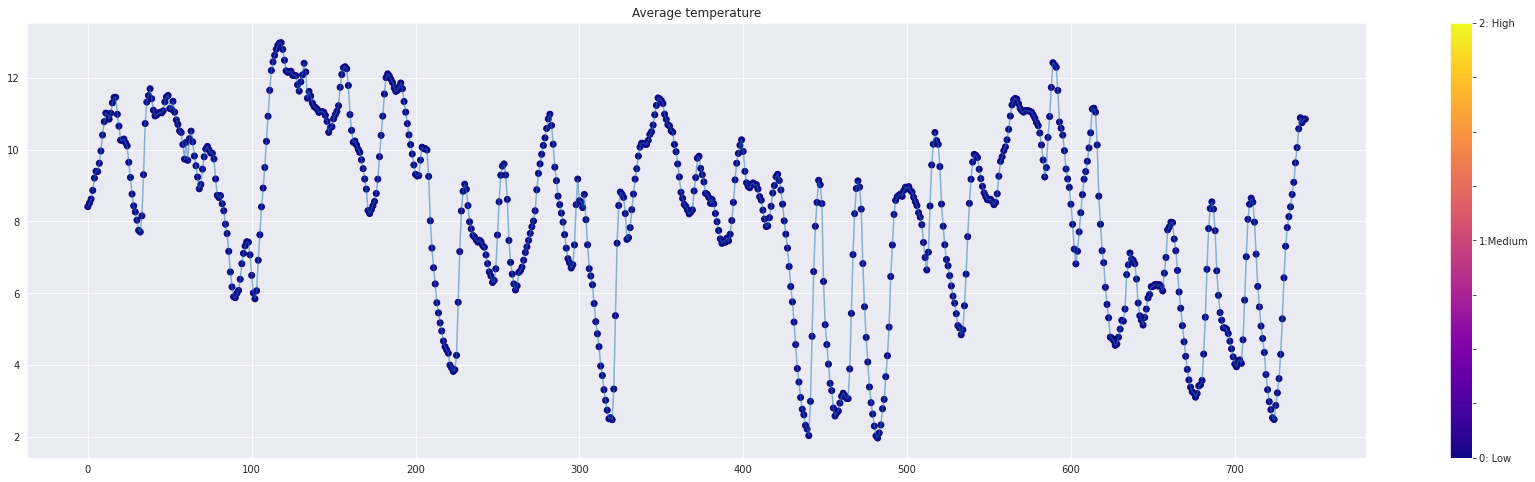

In [ ]:
# Compute the average temperature
y = temperature_df.mean(axis=1)
x = np.arange(y.shape[0])

# Compute the corresponding labels
class_array = []
for i in range(len(temperature_df.index)):
  labels_list = node_labels(i, plot=False)
  c = Counter(labels_list)
  class_array.append(c.most_common()[0][0])

# Display the average temperature for each timestamp with the adapted markers
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(30, 8))
  plt.plot(x, y, alpha=0.5)
  plt.scatter(x, y, c=class_array,cmap="plasma",vmin=0, vmax=2)
  cbar = plt.colorbar()
  plt.title('Average temperature')
  cbar.ax.set_yticklabels(['0: Low','','','','1:Medium','','','','2: High'])
  plt.show()

## Question 8

  0%|          | 0/27528 [00:00<?, ?it/s]

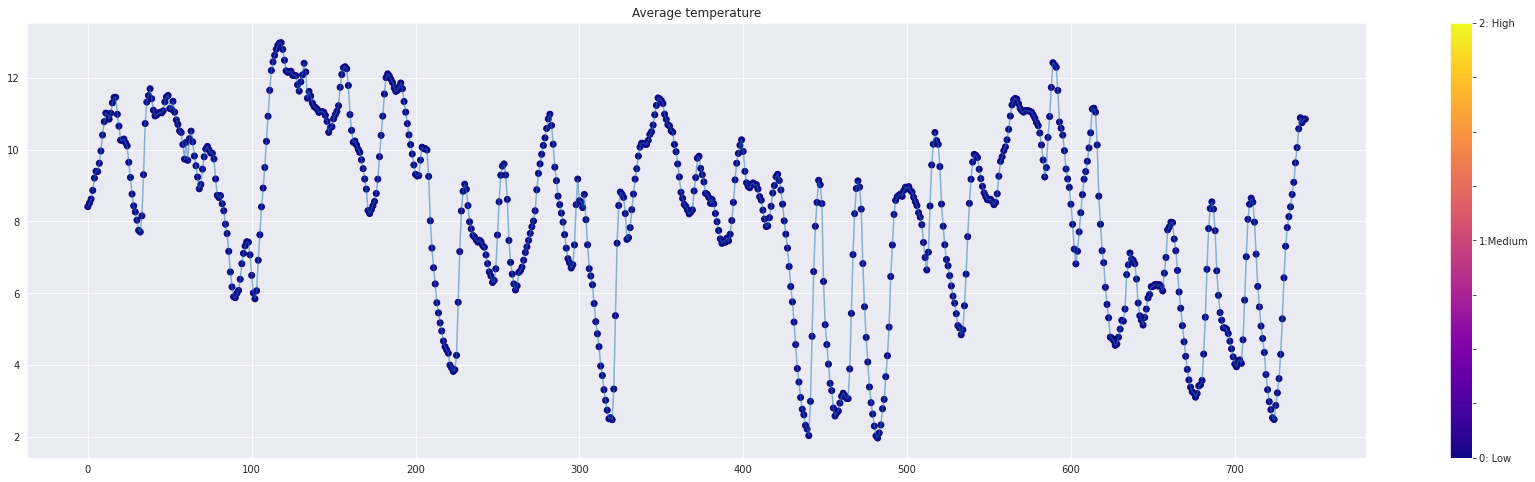

In [ ]:
# Compute the Laplacian matrix for the time dimension 
L_time = get_line_graph(n_nodes=temperature_df.index.size).L.todense()
In = np.eye(L_time.shape[0])

# Compute the Laplacian matrix for the space dimension 
L_space = G_gaussian.L.todense()
Im = np.eye(L_space.shape[0])

# Compute the eigenvalues and eigenvectors of the cartesian product of the previous graphs 
eigenval_time, eigenvec_time = scipy.linalg.eig(L_time)
eigenval_space, eigenvec_space = scipy.linalg.eig(L_space)
eigenval_time = eigenval_time.real
eigenval_space = eigenval_space.real

shape = L_time.shape[0] * L_space.shape[0]
eigenval = np.zeros(shape) 
for i in range(eigenval_time.shape[0]) :
  for j in range(eigenval_space.shape[0]) :
    eigenval[eigenval_space.shape[0]*i+j] = eigenval_time[i] + eigenval_space[j]

eigenvec = np.zeros((shape,shape))
for i in range(eigenval_time.shape[0]) :
  for j in range(eigenval_space.shape[0]) :
     eigenvec[:,eigenval_space.shape[0]*i+j] = np.kron(eigenvec_time[:,i], eigenvec_space[:,j])

# Sort eigenvalues and eigenvectors 
idx = eigenval.argsort()
eigenval = eigenval[idx]
eigenvec = eigenvec[:, idx]

# Compute the Graph Fourrier Transform (GFT) of the graph signal "f"
f = np.ravel(temperature_df.to_numpy(), order='F')
f_hat = eigenvec.T @ f 

M = 9
R = 3

# Compute the corresponding labels
labels = []
for v in tqdm(range(len(f))):
  W_v =[]
  for m in range(1,M+1):
    W = 0
    for i in range(len(eigenval)) :
      W += g_m(eigenval[i], R, m, lambdn=eigenval[-1]) * f_hat[i] * eigenvec[v,i]
    W_v.append(W)
  
  # Classify nodes into low/medium/high frequency
  val = [sum(np.abs(W_v[:3])**2),sum(np.abs(W_v[3:6])**2),sum(np.abs(W_v[6:])**2)]
  labels.append(np.argmax(val))

# Adapt the marker colour to the majority class
labels = np.reshape(np.array(labels),temperature_df.shape)
label_times = []
for i in range(labels.shape[0]):
  unique, counts = np.unique(labels[i], return_counts=True)
  label_times.append(unique[np.argmax(counts)])

# Compute the average temperature
y = temperature_df.mean(axis=1)
x = np.arange(y.shape[0])

# Display the average temperature for each timestamp with the adapted markers of the majority class
with sns.axes_style('darkgrid'):
  plt.figure(figsize=(30, 8))
  plt.plot(x, y, alpha=0.5)
  plt.scatter(x, y, c=label_times,cmap="plasma", vmin= 0 , vmax=2)
  cbar = plt.colorbar()
  plt.title('Average temperature')
  cbar.ax.set_yticklabels(['0: Low','','','','1:Medium','','','','2: High'])
  plt.show()